In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import seq2seq_model
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Bidirectional, Add, LSTM, Flatten, Dropout
from tensorflow import keras
import tensorflow as tf



2023-05-12 16:29:47.223157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
df = pd.read_csv('2249345v4423910.csv', index_col=0)
df

NameError: name 'pd' is not defined

In [3]:
data = df.to_numpy()
data

array([[0.90692641, 0.01455235, 0.42097239, ..., 0.        , 0.        ,
        1.        ],
       [0.90692641, 0.01455235, 0.42097239, ..., 0.        , 0.        ,
        1.        ],
       [0.90692641, 0.01455235, 0.42097239, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 1.10370667, 0.42916334, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.10370667, 0.42916334, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.10370667, 0.42916334, ..., 0.        , 0.        ,
        0.        ]])

In [4]:
train_temp, test = train_test_split(data, test_size=0.8, shuffle=False)
train, val = train_test_split(train_temp, test_size=0.2, shuffle=False)
# train_x, train_y = seq2seq_model.truncate_data(data, 60 * 3, 60)
# train = data[: 60 * 8, :]
# test = data[60 * 8 :, :]
print(test.shape, train.shape)
# print(train_x[2,:,0])
# print(train_y[2,:,0])

(2642, 15) (528, 15)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 75, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 75, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 16)                3216      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 485,633
Trainable params: 485,633
Non-trainab

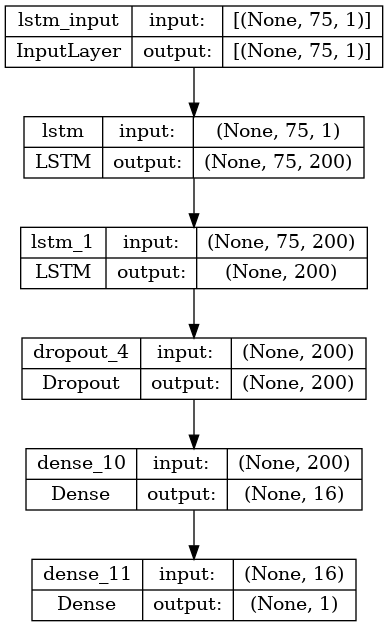

In [5]:
model = load_model("transfer_lstm_model")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True)

In [6]:
# score, scores, actual, predicted = seq2seq_model.evaluate_model(model, train, test, 3, 36, features_out=range(1), features=range(1), features_in_num=1, features_out_num=1, initial_epochs=100, epochs=2, batches_to_train=100000)
window = 75
val_x, val_y = seq2seq_model.truncate_single_step(train, window, features_in=range(1), features_out=range(1))
results = model.evaluate(val_x, val_y)
preds = model.predict(val_x)

15/15 [==============================] - 0s 4ms/step


RMSE:  0.06173925542017593
MAE:  0.06125931441783905


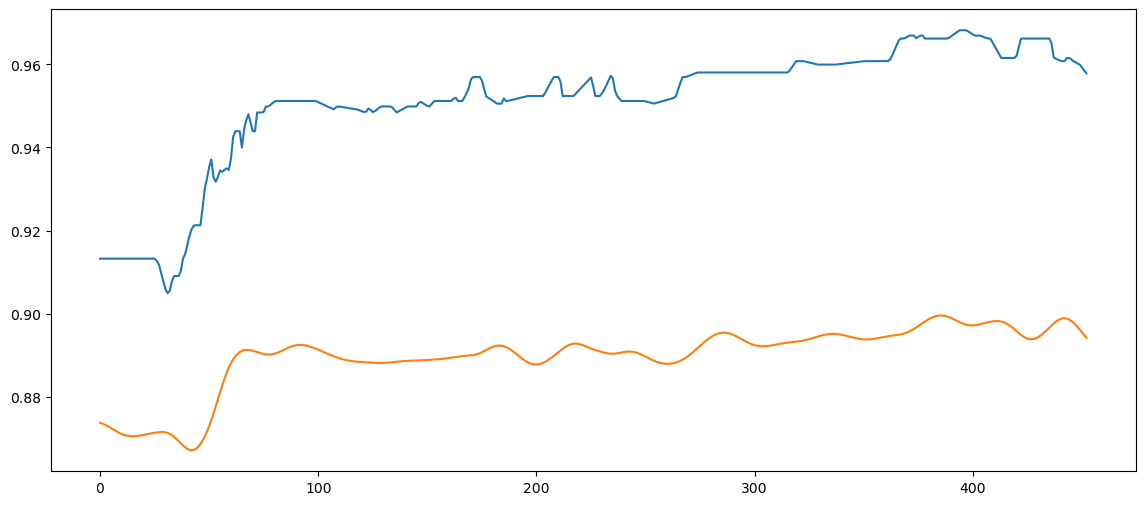

In [7]:
plt.figure(figsize=(14,6))
plt.plot(val_y[:,0])
plt.plot(preds[:,0])
print('RMSE: ', np.sqrt(results[0]))
print('MAE: ', results[1])

In [8]:
train_x, train_y = seq2seq_model.truncate_single_step(train_temp, n_steps=window, features_in=range(1), features_out=range(1))
val_x, val_y = seq2seq_model.truncate_single_step(val, window, features_in=range(1), features_out=range(1))
features_out_num = train_y.shape[1]
print(val_x.shape, val_y.shape)
print(val.shape)
print(train_x.shape, train_y.shape)
x = model.get_layer('lstm_1').output
# x = Dropout(0.2)(x)
x = Dense(16, activation='elu')(x)
x = Dense(features_out_num, activation='sigmoid')(x)
model = keras.models.Model(inputs=model.input, outputs=x)

# x = model.get_layer('bidirectional').output
# y = model.get_layer('bidirectional_1').output
# bd_out_1 = Bidirectional(LSTM(features_out_num, activation='linear'), merge_mode='sum')(x)
# bd_out_2 = Bidirectional(LSTM(features_out_num, activation='tanh'), merge_mode='sum')(y)
# model_out = Add()([bd_out_1, bd_out_2])
# model = keras.models.Model(inputs=model.input, outputs=model_out)

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])
# print(model.get_layer('lstm').get_weights())
history = model.fit(train_x, train_y, epochs=10, batch_size=25, verbose=1)

(57, 75, 1) (57, 1)
(132, 15)
(585, 75, 1) (585, 1)
Epoch 1/10
24/24 [==============================] - 3s 11ms/step - loss: 0.0364 - mae: 0.1275
Epoch 2/10
24/24 [==============================] - 0s 10ms/step - loss: 3.0478e-04 - mae: 0.0134
Epoch 3/10
24/24 [==============================] - 0s 10ms/step - loss: 1.6599e-04 - mae: 0.0102
Epoch 4/10
24/24 [==============================] - 0s 10ms/step - loss: 1.5766e-04 - mae: 0.0102
Epoch 5/10
24/24 [==============================] - 0s 10ms/step - loss: 1.6058e-04 - mae: 0.0098
Epoch 6/10
24/24 [==============================] - 0s 10ms/step - loss: 1.5606e-04 - mae: 0.0095
Epoch 7/10
24/24 [==============================] - 0s 10ms/step - loss: 1.4856e-04 - mae: 0.0096
Epoch 8/10
24/24 [==============================] - 0s 10ms/step - loss: 1.7898e-04 - mae: 0.0101
Epoch 9/10
24/24 [==============================] - 0s 10ms/step - loss: 1.5742e-04 - mae: 0.0095
Epoch 10/10
24/24 [==============================] - 0s 10ms/step - lo

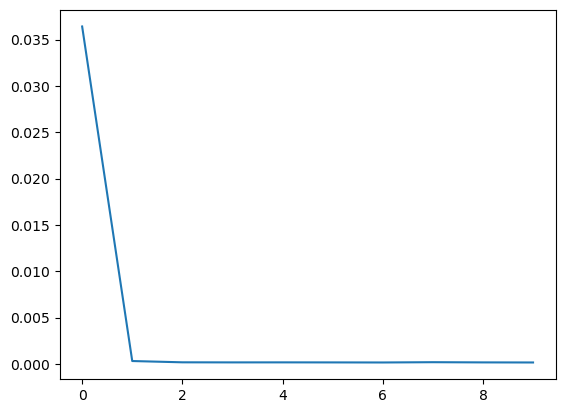

In [9]:
plt.plot(history.history['loss'])

In [10]:
test_x, test_y = seq2seq_model.truncate_single_step(test, window, features_in=range(1), features_out=range(1))
results = model.evaluate(test_x, test_y)
preds = model.predict(test_x)

81/81 [==============================] - 1s 3ms/step


(2567, 1)
RMSE:  0.15910418890628691
MAE:  0.07125237584114075


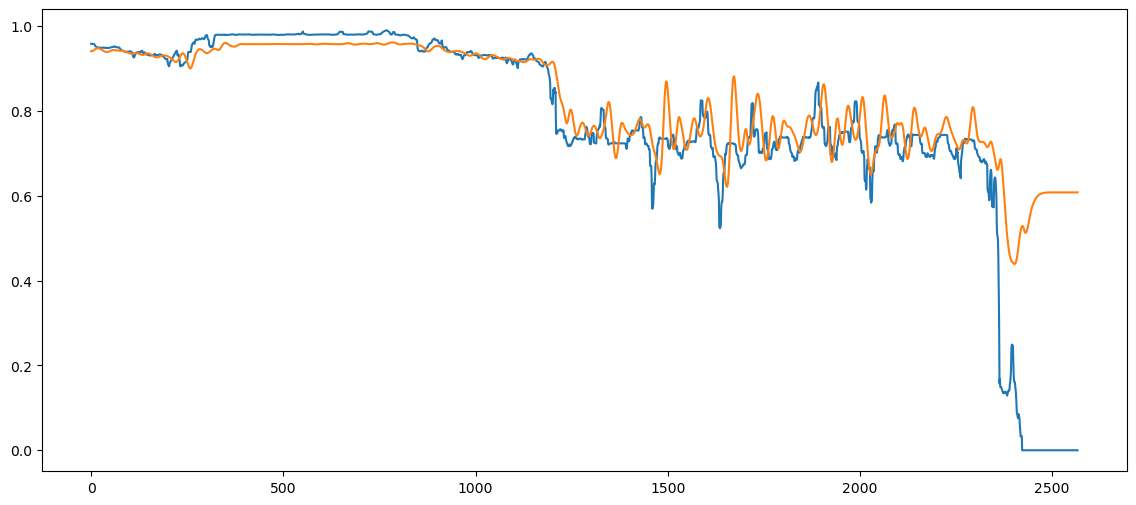

In [11]:
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
plt.plot(preds[:,0])
print(preds.shape)
print('RMSE: ', np.sqrt(results[0]))
print('MAE: ', results[1])

In [12]:
train, test = train_test_split(data, test_size=0.7, shuffle=False)
test_x, test_y = seq2seq_model.truncate_single_step(test, window, features_in=range(1), features_out=range(1))
forecasts = []
i = 0
forecast_window = 36
while i * forecast_window < test_x.shape[0]:
    pred_x_temp = test_x[forecast_window * i, :, :]
    pred_y_temp = test_y[forecast_window * i, :]
    pred_x = pred_x_temp.reshape((1, window, pred_x_temp.shape[1]))
    y_future = []
    for k in range(forecast_window):
        pred_y = model.predict(pred_x)
        y_future.append(pred_y)
        pred_x = np.append(pred_x[:, 1:, :], pred_y.reshape(1, 1, 1), axis=1)
    forecasts.append(y_future)
    pred_x_temp = pred_x_temp.reshape((1, window, test_x.shape[2]))
    pred_y_temp = pred_y_temp.reshape((1, 1))
    train_x = np.vstack((train_x, pred_x_temp))
    train_y = np.vstack((train_y, pred_y_temp))
    i += 1
    if i % 5 == 0:
        model.reset_states()
        model.fit(train_x, train_y, epochs=5, batch_size=25, verbose=1)

1/1 [==============================] - 0s 11ms/step
Epoch 1/5
24/24 [==============================] - 0s 10ms/step - loss: 1.7344e-04 - mae: 0.0099
Epoch 2/5
24/24 [==============================] - 0s 10ms/step - loss: 1.4081e-04 - mae: 0.0092
Epoch 3/5
24/24 [==============================] - 0s 10ms/step - loss: 2.1482e-04 - mae: 0.0110
Epoch 4/5
24/24 [==============================] - 0s 10ms/step - loss: 1.4861e-04 - mae: 0.0095
Epoch 5/5
1/1 [==============================] - 0s 10ms/step
Epoch 1/5
24/24 [==============================] - 0s 9ms/step - loss: 1.2484e-04 - mae: 0.0083
Epoch 2/5
24/24 [==============================] - 0s 10ms/step - loss: 1.2561e-04 - mae: 0.0082
Epoch 3/5
24/24 [==============================] - 0s 10ms/step - loss: 1.2756e-04 - mae: 0.0081
Epoch 4/5
24/24 [==============================] - 0s 10ms/step - loss: 1.1945e-04 - mae: 0.0079
Epoch 5/5
1/1 [==============================] - 0s 10ms/step
Epoch 1/5
24/24 [==============================] 

RMSE:  0.025314142927527428
MAE:  0.07125237584114075
(63, 36, 1, 1)
(2268,)


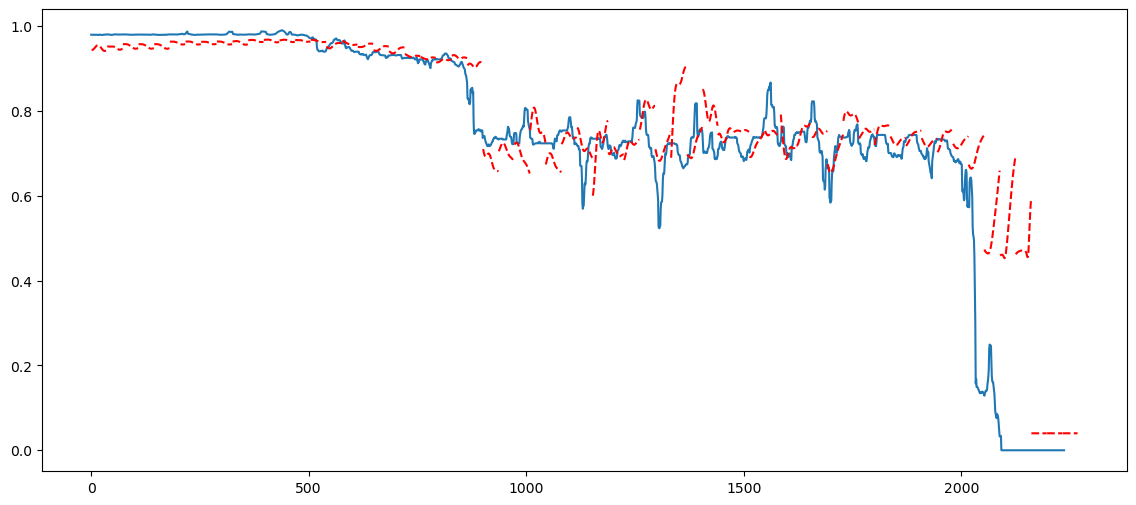

In [13]:
print('RMSE: ', results[0])
print('MAE: ', results[1])
forecasts_arr = np.array(forecasts)
forecasts_flat = forecasts_arr[:, :, 0, 0].flatten()
print(forecasts_arr.shape)
print(forecasts_flat.shape)
df_preds = pd.DataFrame({'Predictions': forecasts_flat}).shift(1)
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
i = 0
idx = 0

while idx + forecast_window <= test_x.shape[0]:
     idx = forecast_window * i + 1
     s_pred = df_preds.iloc[idx:idx + forecast_window]
     plt.plot(s_pred, '--', color='red')
     i += 1

0            NaN
36      0.942980
72      0.946635
108     0.947673
144     0.947758
          ...   
2088    0.659121
2124    0.690478
2160    0.590643
2196    0.040012
2232    0.040012
Name: Predictions, Length: 63, dtype: float32
Mean absolute error of last forecast observation:  0.08256792701794934
Mean squared error of last forecast observation:  0.029537100407063668
Root mean squared error of last forecast observation:  0.17186360989768507


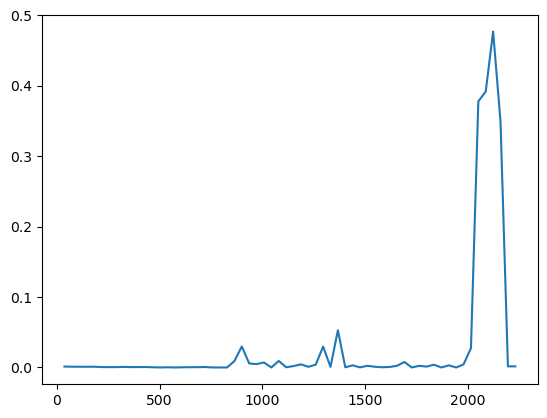

In [14]:
pred_length = test_y.shape[0]
print(df_preds['Predictions'].iloc[:pred_length:36])
df_scores = pd.DataFrame({'Forecasts': df_preds['Predictions'].iloc[:pred_length:36], 'Actual': test_y[1::36,0]})
df_scores['absolute error'] = abs(df_scores['Actual'] - df_scores['Forecasts'])
df_scores['squared error'] = df_scores['absolute error']**(2)
print('Mean absolute error of last forecast observation: ', df_scores['absolute error'].mean())
print('Mean squared error of last forecast observation: ', df_scores['squared error'].mean())
print('Root mean squared error of last forecast observation: ', np.sqrt(df_scores['squared error'].mean()))
plt.plot(df_scores['squared error'])

In [15]:
# print('RMSE: ', score)
# actual_odds = actual.reshape((actual.shape[0]*actual.shape[1]))
# predicted_odds = predicted.reshape((predicted.shape[0]*predicted.shape[1]))
# df_pred = pd.DataFrame({'pred':predicted_odds})
# plt.figure(figsize=(14,6))
# plt.plot(actual_odds)
# for i in range(predicted.shape[0]):
#     idx = 60 * i
#     s_pred = df_pred.iloc[idx:idx + 60]
#     plt.plot(s_pred, '--', color='red')

In [16]:
# plt.figure(figsize=(14,6))
# plt.plot(scores, '-o')